In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath('..'))
from kans import GaussianKAN
from kans.utils import create_dataset

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
# 生成数据集
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
print('train_input size:', dataset['train_input'].shape)
print('train_label',dataset['train_label'].shape)
print('test_input size:', dataset['test_input'].shape)
print('test_label',dataset['test_label'].shape)

# 创建数据加载器
train_dataset = TensorDataset(dataset['train_input'], dataset['train_label'])
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_input size: torch.Size([1000, 2])
train_label torch.Size([1000, 1])
test_input size: torch.Size([1000, 2])
test_label torch.Size([1000, 1])


In [3]:
# 创建模型
layer_sizes = [2,5,3,1]  # 指定每层的节点数
grid_range = [-1,1]  # 指定径向基函数的中心范围
grid_count = 5 # 指定径向基函数的数量
model = GaussianKAN(layer_sizes, grid_range, grid_count)
model.to(device)

# 优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [4]:
# 训练过程
num_epochs = 50
epoch_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 记录损失
        running_loss += loss.item()
        
        # 每隔一定步数打印一次信息
        # if (i + 1) % 10 == 0:
            # print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # 每个epoch结束后输出平均损失
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed. Average Loss: {epoch_loss:.4f}")
    epoch_losses.append(epoch_loss)

# 保存模型
torch.save(model.state_dict(), 'model/gaussian_kan_model.pth')

Epoch [1/50] completed. Average Loss: 3.5930
Epoch [2/50] completed. Average Loss: 1.8625
Epoch [3/50] completed. Average Loss: 0.7803
Epoch [4/50] completed. Average Loss: 0.2364
Epoch [5/50] completed. Average Loss: 0.0703
Epoch [6/50] completed. Average Loss: 0.0253
Epoch [7/50] completed. Average Loss: 0.0076
Epoch [8/50] completed. Average Loss: 0.0060
Epoch [9/50] completed. Average Loss: 0.0052
Epoch [10/50] completed. Average Loss: 0.0052
Epoch [11/50] completed. Average Loss: 0.0035
Epoch [12/50] completed. Average Loss: 0.0030
Epoch [13/50] completed. Average Loss: 0.0026
Epoch [14/50] completed. Average Loss: 0.0026
Epoch [15/50] completed. Average Loss: 0.0041
Epoch [16/50] completed. Average Loss: 0.0049
Epoch [17/50] completed. Average Loss: 0.0023
Epoch [18/50] completed. Average Loss: 0.0016
Epoch [19/50] completed. Average Loss: 0.0022
Epoch [20/50] completed. Average Loss: 0.0020
Epoch [21/50] completed. Average Loss: 0.0018
Epoch [22/50] completed. Average Loss: 0.00

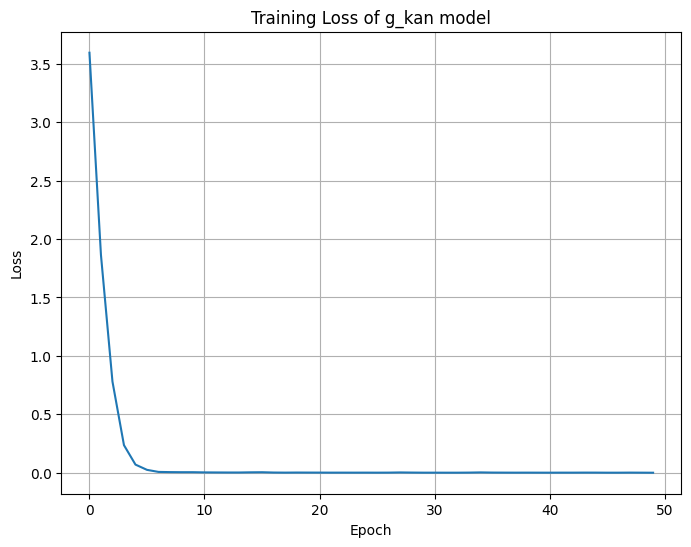

In [5]:
# 画出损失曲线
plt.figure(figsize=(8,6))
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss of g_kan model')
plt.grid(True)
plt.show()

In [6]:
# 加载模型
model = GaussianKAN(layer_sizes, grid_range, grid_count)
model.load_state_dict(torch.load('model/gaussian_kan_model.pth'))

<All keys matched successfully>

In [7]:
# 测试模型
model.eval()
test_input = dataset['test_input']
test_label = dataset['test_label']
with torch.no_grad():
	test_output = model(test_input)
test_loss = criterion(test_output, test_label).item()
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0006
